In [6]:
import math
import torch
import hess
import matplotlib.pyplot as plt
import numpy as np
from hess.nets import Transformer

In [7]:
nx = 500
train_x = torch.linspace(0, 10, nx).unsqueeze(-1)
train_y = torch.sin(train_x * math.pi) + torch.sin(train_x)

In [8]:
optimus = Transformer(train_x, train_y, n_hidden=2, hidden_size=10,
                     activation=torch.nn.Tanh())

In [9]:
trained_pars = torch.load("../hess/saved-models/toy_regression.pt", map_location="cpu")

In [10]:
optimus.net.load_state_dict(trained_pars)

<All keys matched successfully>

In [11]:
hessian = torch.load("../hess/saved-models/toy_hessian.pt", map_location="cpu")

In [30]:
n_test = 1000
test_x = torch.linspace(0, 15, n_test).unsqueeze(-1)
test_y = torch.sin(test_x * math.pi) + torch.sin(test_x)

In [31]:
orig_pred = optimus(test_x)

In [32]:
e_val, e_vec = np.linalg.eig(hessian)
idx = e_val.argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

### Perturb in largest e-vec basis

In [33]:
import hess.utils as utils

In [34]:
top_vecs = e_vec[:, 0:3]

In [35]:
n_pert = 10
scale = 0.05
pert_preds = torch.zeros(n_test, n_pert)

In [36]:
for jj in range(10):
    wghts = torch.randn(3)*0.01
    perturb = top_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)
    print(perturb)
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pert_preds[:, jj] = optimus(test_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

tensor([[ 1.7738e-02, -1.0322e-02, -1.3125e-03, -1.6122e-02, -3.2312e-04,
         -1.0780e-02,  5.7680e-03,  5.4634e-06,  5.5606e-03,  1.8474e-02,
          1.0509e-03,  3.1610e-04,  3.3763e-04, -1.0917e-03, -1.6519e-03,
          3.1872e-04,  9.4725e-04, -1.6678e-03,  9.5078e-04, -3.1743e-04,
         -2.1651e-03, -1.3426e-03, -1.3648e-03,  2.1901e-03,  2.6841e-03,
         -1.3316e-03, -2.1056e-03,  2.6941e-03, -2.1074e-03,  1.3275e-03,
          3.0894e-03,  1.3112e-03,  1.3903e-03, -3.1234e-03, -3.2521e-03,
          1.3198e-03,  2.9755e-03, -3.2498e-03,  2.9800e-03, -1.3149e-03,
         -3.8790e-04, -1.2028e-04, -1.2856e-04,  4.0145e-04,  6.1144e-04,
         -1.2130e-04, -3.5288e-04,  6.2263e-04, -3.5408e-04,  1.2081e-04,
         -7.0593e-03, -2.0860e-03, -2.2234e-03,  7.3082e-03,  1.0452e-02,
         -2.0999e-03, -6.4059e-03,  1.0584e-02, -6.4287e-03,  2.0911e-03,
          2.9633e-03,  7.9804e-04,  8.5445e-04, -3.1056e-03, -5.4090e-03,
          8.0512e-04,  2.6142e-03, -5.

### Perturb in smallest e-vec basis

In [37]:
n_vec = 100
bot_vecs = e_vec[:, -n_vec:]

In [38]:
n_pert = 10
small_pert_preds = torch.zeros(n_test, n_pert)

In [39]:
for jj in range(10):
    wghts = torch.randn(n_vec)
    perturb = bot_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)
    print(perturb.shape)
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
    small_pert_preds[:, jj] = optimus(test_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])


### Plotting

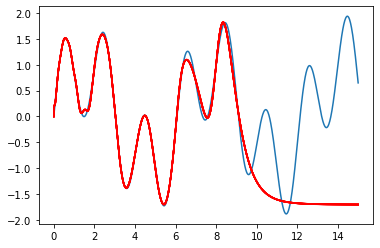

In [40]:
plt.plot(test_x, test_y.detach())
plt.plot(test_x, small_pert_preds.detach(), color="red")

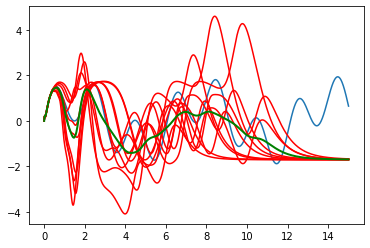

In [41]:
plt.plot(test_x, test_y.detach())
plt.plot(test_x, pert_preds.detach(), color="red")
plt.plot(test_x, pert_preds.mean(-1).detach(), color="green",
        linewidth=2.)

In [42]:
test = optimus(train_x)

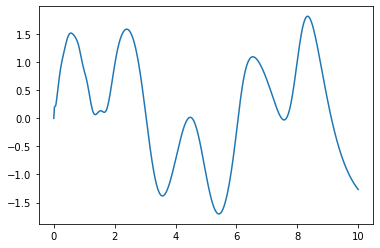

In [43]:
plt.plot(train_x, test.detach())

## Scratch

In [22]:
t1 = torch.randn(100, 1)
t2 = torch.randn(100, 1)

In [23]:
t1.squeeze().dot(t2.squeeze())

tensor(-17.7480)

In [24]:
t1.norm()

tensor(10.6153)

In [25]:
out = [p.data for p in optimus.net.parameters()]